In [1]:
import os
os.chdir('../../')

## GPU 设置

In [2]:
GPUID='0'##调用GPU序号
os.environ["CUDA_VISIBLE_DEVICES"] = GPUID

In [3]:
import numpy as np
import keras.backend as K
from glob import glob
from PIL import Image
import cv2
from keras.layers import Input, Lambda
from keras.models import load_model, Model
from apphelper.image import get_box_spilt,read_voc_xml,resize_im,read_singLine_for_yolo
from text.keras_yolo3 import  preprocess_true_boxes, yolo_text
from train.text.utils import get_random_data_ as get_random_data


def data_generator(roots, anchors, num_classes,splitW):
    '''data generator for fit_generator
    @@roots:jpg/png
    '''
    n = len(roots)
    np.random.shuffle(roots)
    scales = [416,608,608,608]##多尺度训练
    i = 0
    j = 0
    m = len(scales)
    while True:
        root = roots[i]
        i+=1
        if i>=n:
            i=0
        scale = scales[j]
        j+=1
        if j>=m:
            j=0
            
        xmlP  = root.replace('.jpg','.xml').replace('.png','.xml')
        boxes = read_voc_xml(xmlP)
        im    = Image.open(root)
        
        w,h   = resize_im(im.size[0],im.size[1], scale=scale, max_scale=None)
        if max(w,h)>2048:
             w,h   = resize_im(im.size[0],im.size[1], scale=scale, max_scale=2048)
        
        input_shape = (h,w)
        isRoate=True
        rorateDegree=np.random.uniform(-5,5)    
        newBoxes,newIm = get_box_spilt(boxes, im, w,h,splitW=splitW, isRoate=isRoate, rorateDegree=rorateDegree)
        newBoxes = np.array(newBoxes)
        if len(newBoxes)==0:
            continue
        if np.random.randint(0,100)>70:
            if np.random.randint(0,100)>50:
                ##图像水平翻转
                newBoxes[:,[0,2]] = w-newBoxes[:,[2,0]]
                
                im = Image.fromarray(cv2.flip(np.array(im),1))
            else:
                ##垂直翻转
                newBoxes[:,[1,3]] = h-newBoxes[:,[3,1]]
                
                im = Image.fromarray(cv2.flip(np.array(im),0))
                
        
        maxN = 128##随机选取128个box用于训练
        image_data = []
        box_data = []
        
        image, box = get_random_data(newIm,newBoxes, input_shape,max_boxes=maxN)
        
        image_data = np.array([image])
        box_data = np.array([box])
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], [np.zeros(1)]*4
        

Using TensorFlow backend.


## 加载训练数据集，标注XML软件参考https://github.com/cgvict/roLabelImg.git

In [4]:
val_split = 0.1
root='train/data/text/*/*.[j|p]*'
jpgPath   = glob(root)
np.random.shuffle(jpgPath)
num_val   = int(len(jpgPath)*val_split)
num_train = len(jpgPath) - num_val 



## 定义anchors及加载训练模型

In [5]:
## 计算训练集anchors
from train.text.gen_anchors import YOLO_Kmeans## anchors生产
splitW = 8##文本分割最小宽度
#cluster = YOLO_Kmeans(cluster_number=9, root=root, scales=[416, 512, 608, 608, 608, 768, 960, 1024], splitW=splitW)
#8,9, 8,18, 8,31, 8,59, 8,124, 8,351, 8,509, 8,605, 8,800
#print(cluster.anchors)

In [6]:
## 数据事例
from apphelper.image import xy_rotate_box,box_rotate
def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    w,h = img.size
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.size[::-1]
        
    else:
        imgW,imgH = img.size

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['angle']
        w  = line['w']
        h = line['h']
        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree)
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp)

def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def show(p,scale=608):
    im = Image.open(p)
    xmlP  = p.replace('.jpg','.xml').replace('.png','.xml')
    boxes = read_voc_xml(xmlP)
    im    = Image.open(p)
    w,h   = resize_im(im.size[0],im.size[1], scale=scale, max_scale=4096)
    input_shape = (h,w)
    isRoate=True
    
    rorateDegree=np.random.uniform(-5,5)    
    newBoxes,newIm = get_box_spilt(boxes, im, sizeW=w, SizeH=h, splitW=splitW, isRoate=isRoate, rorateDegree=rorateDegree)
    return plot_boxes(im,0, boxes,color=(0,0,0)),plot_box(newIm,newBoxes),newBoxes
a,b,newBoxes = show(jpgPath[10])


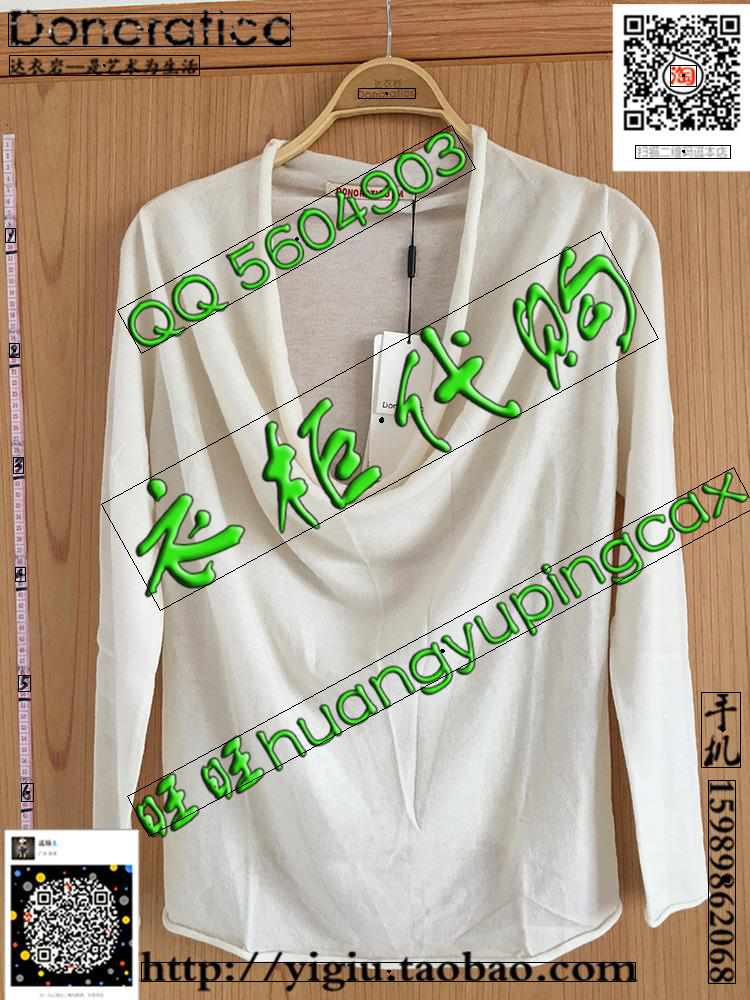

In [7]:
a

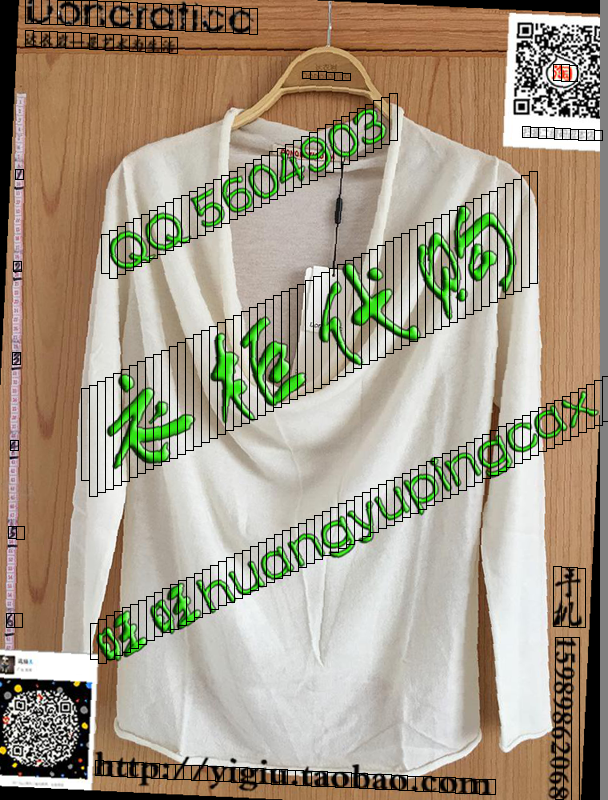

In [8]:
b

In [9]:
#anchors = cluster.anchors
anchors = '8,9, 8,18, 8,31, 8,59, 8,124, 8,351, 8,509, 8,605, 8,800'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)
class_names = ['none','text',]##text 
num_classes = len(class_names)
textModel = yolo_text(num_classes,anchors,train=True)
textModel.load_weights('models/text.h5',skip_mismatch=True)##加载预训练模型权重


In [12]:
trainLoad = data_generator(jpgPath[:num_train], anchors, num_classes,splitW)
testLoad  = data_generator(jpgPath[num_train:], anchors, num_classes,splitW)



In [13]:
from keras.optimizers import Adam
adam = Adam(lr=0.00001)
textModel.compile(optimizer=adam, loss={'xy_loss':lambda y_true, y_pred:y_pred,
                                        'wh_loss':lambda y_true, y_pred:y_pred,
                                        'confidence_loss':lambda y_true, y_pred:y_pred,
                                        'class_loss':lambda y_true, y_pred:y_pred,
                                   }
                                    )


In [14]:
textModel.fit_generator(generator=trainLoad, 
                         steps_per_epoch=num_train, 
                         epochs=10,
                         verbose=1, 
                         callbacks=None,
                         validation_data=testLoad, 
                         validation_steps=num_val)

Epoch 1/10
179/179 [==============================] - 55s 305ms/step - loss: 1.2524 - class_loss_loss: 8.2864e-04 - xy_loss_loss: 0.2758 - wh_loss_loss: 0.0026 - confidence_loss_loss: 0.7188 - val_loss: 1.5857 - val_class_loss_loss: 0.0010 - val_xy_loss_loss: 0.2663 - val_wh_loss_loss: 0.0038 - val_confidence_loss_loss: 1.0603
Epoch 2/10
179/179 [==============================] - 35s 197ms/step - loss: 1.2342 - class_loss_loss: 7.4268e-04 - xy_loss_loss: 0.2731 - wh_loss_loss: 0.0024 - confidence_loss_loss: 0.7039 - val_loss: 1.3406 - val_class_loss_loss: 8.1517e-04 - val_xy_loss_loss: 0.2611 - val_wh_loss_loss: 0.0024 - val_confidence_loss_loss: 0.8224
Epoch 3/10
179/179 [==============================] - 34s 187ms/step - loss: 1.3281 - class_loss_loss: 8.4353e-04 - xy_loss_loss: 0.2785 - wh_loss_loss: 0.0026 - confidence_loss_loss: 0.7925 - val_loss: 1.3344 - val_class_loss_loss: 9.2627e-04 - val_xy_loss_loss: 0.2678 - val_wh_loss_loss: 0.0031 - val_confidence_loss_loss: 0.8092
Epoch

In [ ]:
textModel.save_weights('./train/text.h5')